## Matrix Factorization

In [1]:
import os
import numpy as np
import pandas as pd

from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
rating_df = pd.read_csv('./data/ml-latest-small/ratings.csv', encoding='utf-8')

print(rating_df.shape)
display(rating_df.head())

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state = 42)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [5]:
train_df.head()

,userId,movieId,rating,timestamp
80568,509,7347,3.0,1435994597
50582,326,71462,4.0,1322252335
8344,57,2115,3.0,965798155
99603,610,1127,4.0,1479544102
71701,462,2409,2.0,1174438249


In [115]:
spares_matrix = pd.pivot(data = train_df,
                         index = 'movieId',
                         columns = 'userId',
                         values = 'rating')

In [123]:
sparse_matrix = spares_matrix.fillna(0).to_numpy()

# sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)
# sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

print(sparse_matrix.shape)
print(type(sparse_matrix))

(8983, 610)
<class 'numpy.ndarray'>


In [127]:
sparse_matrix

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## Matrix Factorization 구현

In [131]:
class MatrixFactorization():
    def __init__(self, matrix, k, alpha, beta, iterations):
        
        self.matrix = matrix  # User-Item rating value Matrix

        # 사용자 수, 아이템 수
        self.num_users, self.num_items = matrix.shape

        # latent dimension 수
        self.k = k

        # Learning Rate
        self.alpha = alpha

        # regularization parameter
        self.beta = beta

        # Epoch 수
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent dimension
        self.P = np.random.normal(scale= 1./self.k, 
                                  size = (self.num_users, self.k))
        self.Q = np.random.normal(scale = 1. / self.k,
                                  size = ((self.num_items, self.k)))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.matrix[np.where(self.matrix != 0)])

        # 샘플 리스트 (0이 아닌 샘플들만)
        self.samples = [
            (i, j, self.matrix[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.matrix[i, j] > 0
        ]

        # SGD
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            # if (i + 1) % 10 == 0:
            print('Iteration : %d / MSE = %.4f' % (i+1, mse))

        return training_process
    

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.matrix.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.matrix[x, y] - predicted[x, y], 2)
        return np.sqrt(error)


    def sgd(self):
        for i, j, r in self.samples:
            pred = self.get_rating(i, j)
            e = (r - pred)

            # bias 업데이트
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])



    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)


In [132]:
mf = MatrixFactorization(sparse_matrix, 100, 0.01, 0.01, 10)

In [133]:
training_process = mf.train()

Iteration : 1 / MSE = 254.7316
Iteration : 2 / MSE = 247.9246
Iteration : 3 / MSE = 244.2212
Iteration : 4 / MSE = 241.5879
Iteration : 5 / MSE = 239.4751
Iteration : 6 / MSE = 237.7994
Iteration : 7 / MSE = 236.3077
Iteration : 8 / MSE = 234.7309
Iteration : 9 / MSE = 232.8551
Iteration : 10 / MSE = 230.8194


    - 너무 sparse해서 그런가? 결과 별로

In [134]:
mf = MatrixFactorization(sparse_matrix, 300, 0.01, 0.01, 10)
training_process = mf.train()

Iteration : 1 / MSE = 254.9242
Iteration : 2 / MSE = 248.0578
Iteration : 3 / MSE = 244.3177
Iteration : 4 / MSE = 241.7449
Iteration : 5 / MSE = 239.8789
Iteration : 6 / MSE = 238.2455
Iteration : 7 / MSE = 236.9203
Iteration : 8 / MSE = 235.7433
Iteration : 9 / MSE = 234.4356
Iteration : 10 / MSE = 233.1958


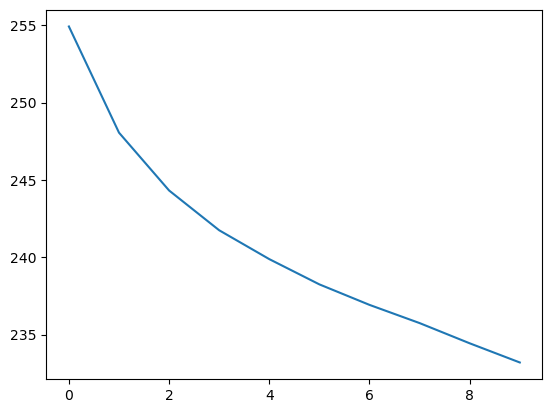

In [135]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]

plt.plot(x, y)